# Notebooks in ArcGIS Pro

## Introduction

In this notebook you will cover these topics:
* [ArcGIS Python environment](#env)
* [How to work with Jupyter Notebooks using ArcGIS Python environment in VS Code](#outside)
* [How to work with Jupyter Notebooks in ArcGIS Pro](#inside)
* [ArcPy exercises](#arcpy)

## ArcGIS Python environment <a id="env"></a>

ArcGIS Pro uses its own Python environment to store and install packages in a similar way you craeted your own conda Python environment. Start ArcGIS Pro and go to Settings.

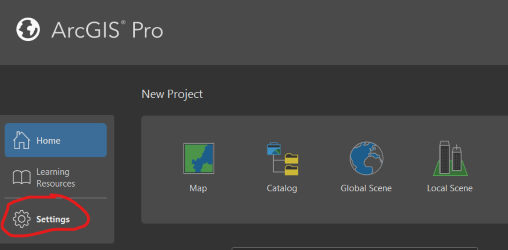

Jupyter Notebooks are implemented in ArcGIS Pro, you can create a new notebook, add an existing one, edit and run it. Go to Package manager and type "jupyter" in the search bar. You'll see that the ArcGIS Pro Python environment contains all Jupyter packages including ```ipykernel``` which you needed to install into the conda environment.

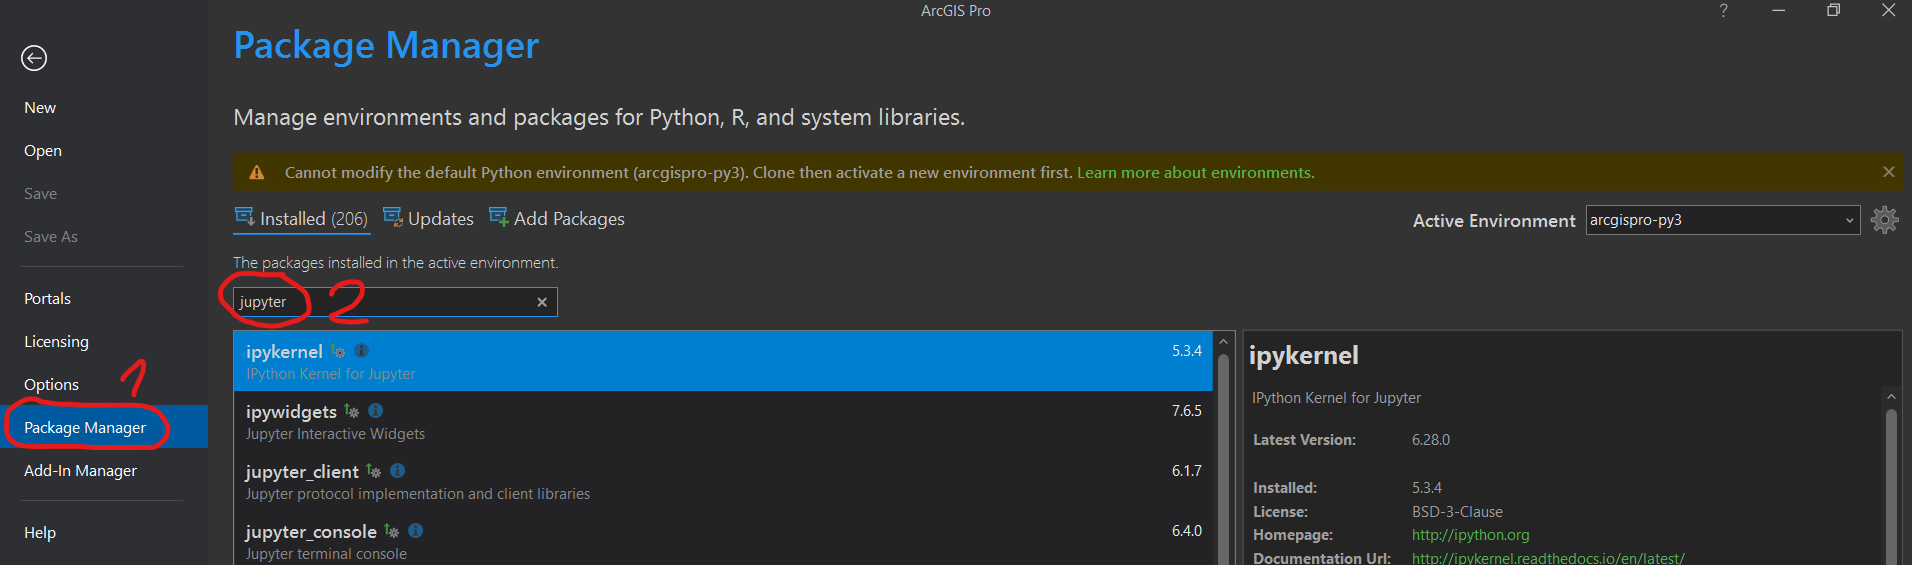

If you want to work with notebooks in ArcGIS Pro and you don't need some other packages that are not installed in this default environment, you can just jump straight into it.

In case you want to use this Python environment outside of ArcGIS Pro or you want to use some other Python packages, you need to clone this default environment. The scheme below shows how to do it.

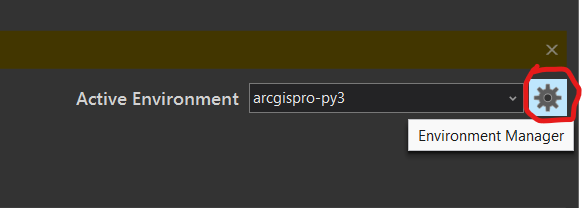

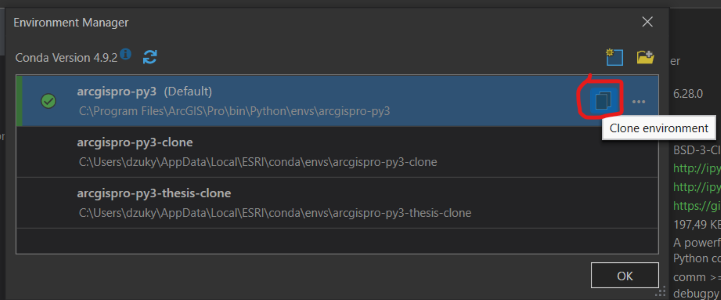

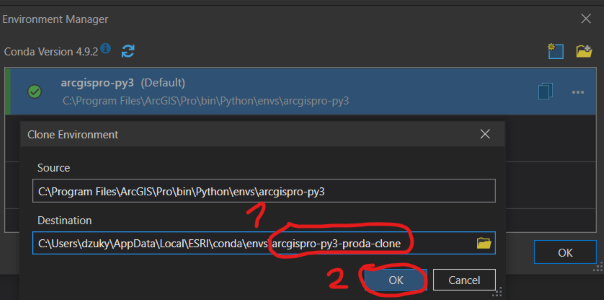

Add and create options are located under the "Insert" tab.

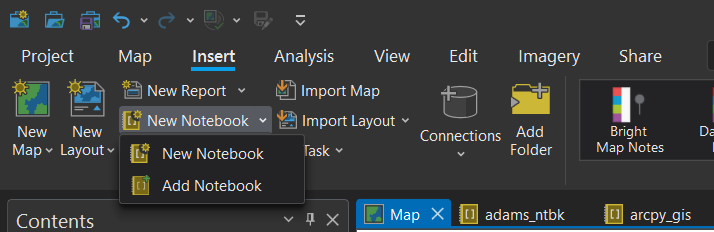

## How to work with Jupyter Notebooks using ArcGIS Python environment in VS Code <a id="outside"></a>

## How to work with Jupyter Notebooks in ArcGIS Pro <a id="inside"></a>

## ArcPy exercises <a id="arcpy"></a>

1. Import ```arcpy``` package, set your project's .gdb as a workspace and allow overwriting outputs with the same name.

In [ ]:
import arcpy
print("arcpy imported")
#arcpy.env.overwriteOutput=True
#arcpy.env.workspace = r"D:\diplomka\cvicenie\cvicenie.gdb"


Potom vyexportujte obec Lutín z vrstvy "Obce – Body" z ArcČR 3.3. Okolo tejto obce vytvorte 10 km buffer.

In [ ]:

#arcpy.management.SelectLayerByAttribute("D:/ArcCR33/AdministrativniCleneni_v13.gdb/ObceBody", "NEW_SELECTION", "NAZ_OBEC = 'Lutín'")
arcpy.conversion.ExportFeatures("D:/ArcCR33/AdministrativniCleneni_v13.gdb/ObceBody", "lutin_bod", "NAZ_OBEC = 'Lutín'")
print("Lutin exported")
arcpy.analysis.Buffer("lutin_bod", "lutin_buffer", "10 Kilometers")
print("buffer created")

2. Nástrojom Clip orežte vrstvy z ArcČR 3.3 "Lesy", "SidlaPlochy", "Silnice_2016", "VodniToky" a "Obce - Polygony" vytvoreným bufferom a uložte ich do .gdb vášho projektu.

In [7]:
acr = "D:/ArcCR33/ArcCR500_v33.gdb/"
vstup = [acr+"Lesy", acr+"SidlaPlochy", acr+"Silnice_2016", acr+"VodniToky", "D:/ArcCR33/AdministrativniCleneni_v13.gdb/ObcePolygony"]
vystup = ["lesy_cl", "sidla_cl", "silnice_cl", "vodni_toky_cl", "obcepolygony_cl"]

for i in range(len(vstup)):
    arcpy.analysis.Clip(vstup[i], "lutin_buffer", vystup[i])
print("everything clipped")

everything clipped


3. Vypíšte extent a počet prvkov clipnutých vrstiev.

In [11]:
for i in vystup:
    cnt =  arcpy.management.GetCount(i)
    print(f"pocet prvkov vo vrstve {i} je {cnt}")
    dscrb = arcpy.Describe(i)
    ext = dscrb.extent
    print(f"extent: {ext}")
    print(" ")
    

pocet prvkov vo vrstve klzm_cl je 43
extent: -566429,570263587 -1135284,15713008 -546429,572413199 -1115284,15743766 NaN NaN NaN NaN
 
pocet prvkov vo vrstve lesy_cl je 6
extent: -566407,920827255 -1127727,63159972 -558759,192145087 -1116357,87102816 NaN NaN NaN NaN
 
pocet prvkov vo vrstve sidla_cl je 2
extent: -561871,006530989 -1135283,99956685 -546609,807708215 -1119515,44309665 NaN NaN NaN NaN
 
pocet prvkov vo vrstve silnice_cl je 163
extent: -566424,082708199 -1135284,05387459 -546435,209696319 -1115409,62003461 NaN NaN NaN NaN
 
pocet prvkov vo vrstve vodni_toky_cl je 27
extent: -566356,937901143 -1135231,60690939 -546429,79131978 -1116064,56780489 NaN NaN NaN NaN
 
pocet prvkov vo vrstve obcepolygony_cl je 43
extent: -566429,570978286 -1135284,15708019 -546429,572365155 -1115284,1575 NaN NaN NaN NaN
 


4. Spočítajte celkovú dĺžku ciest vo vrstve "silnice_cl". Výsledok uveďte v km s presnosťou na 2 desatinné miesta. V tejto vrstve tiež nájdite najdlhšiu cestu a vypíšte jej dĺžku a ID.

In [18]:
dlzka = 0
maxdlzka = 0
maxid = 0

with arcpy.da.SearchCursor("silnice_cl", ["OBJECTID", "SHAPE_Length"]) as cursor:
    for row in cursor:
        dlzka += row[1]
        if row[1] > maxdlzka:
            maxdlzka = row[1]
            maxid = row[0]
        
print("celkova dlzka ciest je " + str(round((dlzka/1000), 4)) + " km")
print(f"najdlhsia cesta ma id {maxid} a dlzku {maxdlzka} m")

celkova dlzka ciest je 245.0529 km
najdlhsia cesta ma id 85 a dlzku 6887.6805779802935 m


5. Vypočítajte hustotu ciest (km/km2) v clipnutých obciach a zapíšte ju do nového atribútového poľa "hustota".

In [20]:
arcpy.analysis.Intersect(["silnice_cl", "obcepolygony_cl"], "silnice_isect", "ONLY_FID")
print("intersected")

arcpy.management.Dissolve("silnice_isect", "silnice_isect_diss", "FID_obcepolygony_cl")
print("dissolved")

arcpy.management.AddField("silnice_isect_diss", "dlzka_ciest", "DOUBLE")
arcpy.management.CalculateField("silnice_isect_diss", "dlzka_ciest", '!SHAPE_Length!')
print("done")

arcpy.management.JoinField("obcepolygony_cl", "OBJECTID", "silnice_isect_diss", "FID_obcepolygony_cl", ["dlzka_ciest"])
arcpy.management.AddField("obcepolygony_cl", "hustota", "DOUBLE")
arcpy.management.CalculateField("obcepolygony_cl", "hustota", '(!dlzka_ciest!/1000)/(!SHAPE_Area!/1000000)')
print("hustota vypocitana")

intersected
